# 📊 BACKTEST HISTÓRICO CON VENTANAS DESLIZANTES (QUANTFURY)

Este notebook implementa un backtest histórico completo usando ventanas deslizantes de 5 años (2015-2025).

## Comparación: Gestión ACTIVA vs PASIVA

**CON DCA (Activo)**: Rebalanceo activo + despliegue condicional
**SIN DCA (Pasivo)**: Sin rebalancing + solo mantiene leverage mínimo

Ambas estrategias usan contribuciones mensuales de $2,000 y reborrow.

# 📦 Bloque 1: Configuración del entorno

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import datetime

# ==============================================================================
# CONFIGURATION: Same parameters as Monte Carlo simulation
# ==============================================================================

METAPARAMETERS = {
    "initial_capital": 60_000,  # Starting Equity/Collateral in USD
    "monthly_contribution": 2_000,  # New Equity injected every month
    "leverage": 2.5,  # Leverage ratio
    "max_weight": 0.35,  # Constraint: Maximum weight per asset
    "min_weight": 0.10,  # Constraint: Minimum weight per asset
    "maintenance_margin_ratio": 0.05,  # Margin call triggers at 5% of exposure
    "drawdown_redeploy_threshold": 0.12,  # Drawdown level (12%) for full DCA
    "weight_deviation_threshold": 0.05,  # Max tolerated deviation from target weights
    "volatility_lookback_days": 63,  # Lookback window for volatility
    "volatility_redeploy_threshold": 0.18,  # Annualized volatility threshold
    "safe_margin_ratio": 0.20,  # Safe margin level (20%)
    "critical_margin_ratio": 0.10,  # Critical margin level (10%)
    "gradual_deploy_factor": 0.5,  # Fraction of DCA to deploy gradually
    "redeploy_leverage_threshold": 3.0,  # Redeploy leverage threshold
}

# Portfolio weights (optimized from Monte Carlo simulation)
PORTFOLIO_OPTIMIZED = {
    "QQQ": 0.22,
    "SPY": 0.22,
    "EZU": 0.20,
    "GLD": 0.16,
    "BTC-USD": 0.20,
}

# Backtest configuration: Rolling 5-year windows
# From January 2015 to October 2020 (start months)
# Each window is 5 years long
ROLLING_START_YEAR = 2015
ROLLING_START_MONTH = 1  # January
ROLLING_END_YEAR = 2020
ROLLING_END_MONTH = 10  # October
WINDOW_YEARS = 5

yearly_trading_days = 252


#

# 📥 Bloque 2: Función de descarga de datos

In [3]:
def download_backtest_data(tickers, start_date, end_date, verbose=True):
    """
    Download historical price data for the backtest period.

    Args:
        tickers: Dictionary of ticker symbols
        start_date: Start date for backtest
        end_date: End date for backtest
        verbose: If True, print progress messages

    Returns:
        log_returns: DataFrame with daily log returns
        prices: DataFrame with adjusted close prices
    """
    if verbose:
        print(f"\n📥 Descargando datos: {start_date} a {end_date}")

    # Convert to datetime for yfinance
    start_datetime = datetime.datetime.combine(start_date, datetime.time())
    end_datetime = datetime.datetime.combine(end_date, datetime.time())

    data = yf.download(
        list(tickers.keys()),
        start=start_datetime,
        end=end_datetime,
        progress=False,  # Disable progress bar for multiple downloads
    )

    # Extract prices
    prices = pd.DataFrame()
    if "Adj Close" in data.columns.get_level_values(0):
        prices = data["Adj Close"].copy()
    if "Close" in data.columns.get_level_values(0):
        close_prices = data["Close"]
        if prices.empty:
            prices = close_prices.copy()
        else:
            prices.fillna(close_prices, inplace=True)

    if prices.empty:
        raise ValueError(
            f"ERROR: No se pudieron descargar los datos para {start_date} a {end_date}"
        )

    # Ensure all tickers are present
    missing_tickers = set(tickers.keys()) - set(prices.columns)
    if missing_tickers:
        if verbose:
            print(f"⚠️  Advertencia: Faltan tickers: {missing_tickers}")

    # Calculate log returns
    log_returns = np.log(prices / prices.shift(1)).dropna()

    if verbose:
        print(f"   ✅ {len(log_returns)} días de trading")

    return log_returns, prices

# 📅 Bloque 3: Generación de ventanas deslizantes

In [4]:
def generate_rolling_windows(
    start_year, start_month, end_year, end_month, window_years
):
    """
    Generate list of rolling window date ranges.

    Args:
        start_year: Starting year for first window
        start_month: Starting month for first window
        end_year: Ending year for last window start
        end_month: Ending month for last window start
        window_years: Length of each window in years

    Returns:
        List of tuples: [(start_date, end_date), ...]
    """
    windows = []
    current_year = start_year
    current_month = start_month

    while (current_year < end_year) or (
        current_year == end_year and current_month <= end_month
    ):
        window_start = datetime.date(current_year, current_month, 1)

        # Calculate end date (5 years later, same month)
        end_year_window = current_year + window_years
        window_end = datetime.date(end_year_window, current_month, 1)

        windows.append((window_start, window_end))

        # Move to next month
        if current_month == 12:
            current_month = 1
            current_year += 1
        else:
            current_month += 1

    return windows

# 💰 Bloque 4: Inicialización de cartera

In [5]:
def initialize_portfolio(verbose=True):
    """
    Initialize portfolio state with starting capital and positions.

    Args:
        verbose: If True, print initialization details

    Returns:
        dict: Initial portfolio state
    """
    initial_capital = METAPARAMETERS["initial_capital"]
    leverage = METAPARAMETERS["leverage"]
    weights_array = np.array(list(PORTFOLIO_OPTIMIZED.values()))
    asset_names = list(PORTFOLIO_OPTIMIZED.keys())

    # Initial trading power
    initial_tp = initial_capital * leverage
    initial_position_values = initial_tp * weights_array

    portfolio_state = {
        "capital": initial_capital,
        "position_values": initial_position_values.copy(),
        "peak_capital": initial_capital,
        "equity_history": [],  # For volatility calculation
        "cash_flow_history": [-initial_capital],
        "monthly_distributions": [],  # Track monthly DCA deployments
        "daily_equity": [initial_capital],  # Track equity over time
        "daily_exposure": [np.sum(initial_position_values)],  # Track exposure over time
        "days_since_month_start": 0,
    }

    if verbose:
        print("\n💰 Inicializando cartera")
        print(f"Capital inicial: ${initial_capital:,.0f}")
        print(f"Leverage objetivo: {leverage}x")
        print(f"Trading Power inicial: ${initial_tp:,.0f}")

    return portfolio_state, asset_names, weights_array

# 📉 Bloque 5: Aplicación de retornos diarios

In [6]:
def apply_daily_returns(
    portfolio_state, daily_returns_array, asset_names, weights_array
):
    """
    Apply daily returns to portfolio positions and update capital.

    Args:
        portfolio_state: Current portfolio state
        daily_returns_array: Array of log returns for each asset
        asset_names: List of asset names
        weights_array: Target portfolio weights

    Returns:
        bool: True if portfolio is still active, False if margin call occurred
    """
    position_values = portfolio_state["position_values"]
    capital = portfolio_state["capital"]

    # Calculate PnL for each asset
    pnl_by_asset = position_values * (np.exp(daily_returns_array) - 1)
    daily_pnl = np.sum(pnl_by_asset)

    # Update position values and capital
    position_values += pnl_by_asset
    capital += daily_pnl

    # Check for margin call
    exposure = np.sum(position_values)
    margin_ratio = capital / exposure if exposure > 0 else 1.0
    MAINTENANCE_RATIO = METAPARAMETERS["maintenance_margin_ratio"]

    margin_call = False
    if exposure > 0 and (capital <= 0 or margin_ratio <= MAINTENANCE_RATIO):
        margin_call = True
        capital = 0
        position_values.fill(0)

    # Update portfolio state
    portfolio_state["capital"] = capital
    portfolio_state["position_values"] = position_values
    portfolio_state["peak_capital"] = max(portfolio_state["peak_capital"], capital)

    return not margin_call

# 🔄 Bloque 6: Rebalanceo mensual y DCA

In [7]:
def apply_monthly_rebalancing(
    portfolio_state, asset_names, weights_array, day_idx, log_returns, enable_dca=True
):
    """
    Apply monthly DCA contribution and rebalancing according to strategy rules.

    Args:
        portfolio_state: Current portfolio state
        asset_names: List of asset names
        weights_array: Target portfolio weights
        day_idx: Current day index
        log_returns: DataFrame with historical log returns (for volatility calculation)
        enable_dca: If True, use conditional DCA strategy; if False, keep contributions as buffer

    Returns:
        dict: Monthly distribution record
    """
    # Constants
    LEVERAGE = METAPARAMETERS["leverage"]
    MONTHLY_CONTRIBUTION = METAPARAMETERS["monthly_contribution"]
    DRAWDOWN_THRESHOLD = METAPARAMETERS["drawdown_redeploy_threshold"]
    WEIGHT_DEVIATION_THRESHOLD = METAPARAMETERS["weight_deviation_threshold"]
    VOLATILITY_THRESHOLD = METAPARAMETERS["volatility_redeploy_threshold"]
    SAFE_MARGIN = METAPARAMETERS["safe_margin_ratio"]
    CRITICAL_MARGIN = METAPARAMETERS["critical_margin_ratio"]
    GRADUAL_DEPLOY_FACTOR = METAPARAMETERS["gradual_deploy_factor"]
    VOLATILITY_LOOKBACK_DAYS = METAPARAMETERS["volatility_lookback_days"]

    capital = portfolio_state["capital"]
    position_values = portfolio_state["position_values"]
    peak_capital = portfolio_state["peak_capital"]

    # Calculate indicators
    exposure = np.sum(position_values)
    current_margin_ratio = capital / exposure if exposure > 0 else 1.0

    # Drawdown
    drawdown = 0.0
    if peak_capital > 0:
        drawdown = (capital / peak_capital) - 1.0

    # Weight deviation
    weight_deviation = 0.0
    current_tp = exposure
    if current_tp > 0:
        current_weights = position_values / current_tp
        weight_deviation = np.max(np.abs(current_weights - weights_array))

    # Realized volatility
    realized_vol = np.nan
    equity_history = portfolio_state["daily_equity"]
    if len(equity_history) >= 2:
        lookback_end = len(equity_history)
        lookback_start = max(0, lookback_end - VOLATILITY_LOOKBACK_DAYS - 1)
        window_equity = np.array(equity_history[lookback_start:lookback_end])
        if len(window_equity) > 1:
            returns_window = np.diff(np.log(window_equity))
            if len(returns_window) > 0:
                if len(returns_window) > 1:
                    daily_vol = np.std(returns_window, ddof=1)
                else:
                    daily_vol = np.std(returns_window)
                realized_vol = daily_vol * np.sqrt(yearly_trading_days)

    # Add monthly contribution
    capital += MONTHLY_CONTRIBUTION
    portfolio_state["cash_flow_history"].append(-MONTHLY_CONTRIBUTION)

    # If DCA disabled: Passive management - contributions to maintain leverage, no active rebalancing
    if not enable_dca:
        # Always use LEVERAGE for passive mode (no dynamic leverage in backtest)
        desired_tp = capital * LEVERAGE

        # Calculate how much exposure we need to add
        exposure_needed = max(0, desired_tp - current_tp)

        capital_distribution = {asset: 0.0 for asset in asset_names}
        equity_used_from_contribution = 0.0

        if exposure_needed > 0:
            # Distribute according to CURRENT weights (passive - no rebalancing)
            current_weights = (
                position_values / current_tp if current_tp > 0 else weights_array
            )

            # Calculate equity needed for this exposure increase
            equity_needed = (
                exposure_needed / LEVERAGE if LEVERAGE > 0 else exposure_needed
            )
            equity_used_from_contribution = min(MONTHLY_CONTRIBUTION, equity_needed)

            # Add positions proportionally to current weights
            additional_exposure = equity_used_from_contribution * LEVERAGE
            additional_positions = additional_exposure * current_weights
            position_values += additional_positions

            # Track distribution
            for idx, asset in enumerate(asset_names):
                capital_distribution[asset] = (
                    equity_used_from_contribution * current_weights[idx]
                )

        new_total_tp_used = np.sum(position_values)
        held_as_buffer = MONTHLY_CONTRIBUTION - equity_used_from_contribution

        # Update portfolio state
        portfolio_state["capital"] = capital
        portfolio_state["position_values"] = position_values
        portfolio_state["peak_capital"] = max(peak_capital, capital)

        # Create monthly distribution record
        month_num = (day_idx // int(yearly_trading_days / 12)) + 1
        monthly_record = {
            "month": month_num,
            "capital_added_to_positions": equity_used_from_contribution,
            "margin_buffer": held_as_buffer,
            "distribution": capital_distribution.copy(),
            "drawdown": drawdown,
            "weight_deviation": weight_deviation,
            "realized_volatility": realized_vol,
            "deploy_fraction": 0.0,  # No conditional deployment in passive mode
            "margin_ratio": current_margin_ratio,
        }

        portfolio_state["monthly_distributions"].append(monthly_record)
        return monthly_record

    # DCA Strategy: Calculate deploy fraction
    deploy_fraction = 0.0
    if drawdown <= -DRAWDOWN_THRESHOLD:
        deploy_fraction = 1.0
    else:
        weight_condition = weight_deviation >= WEIGHT_DEVIATION_THRESHOLD
        vol_condition = (not np.isnan(realized_vol)) and (
            realized_vol <= VOLATILITY_THRESHOLD
        )
        if weight_condition or vol_condition:
            deploy_fraction = 1.0

    # Apply margin-based scaling
    if current_margin_ratio < CRITICAL_MARGIN:
        deploy_fraction = 0.0
    elif current_margin_ratio < SAFE_MARGIN:
        margin_range = SAFE_MARGIN - CRITICAL_MARGIN
        if margin_range > 0:
            margin_factor = (current_margin_ratio - CRITICAL_MARGIN) / margin_range
            deploy_fraction = deploy_fraction * margin_factor

    if deploy_fraction > 0:
        deploy_fraction = min(deploy_fraction, GRADUAL_DEPLOY_FACTOR)

    # Calculate target trading power
    desired_tp = capital * LEVERAGE

    # STRATEGY: Reborrow to maintain minimum leverage (always when safe)
    # This is independent of DCA deployment conditions
    if desired_tp > current_tp:
        # Need to increase exposure to maintain leverage
        target_tp = desired_tp
    elif current_tp > desired_tp:
        # Need to reduce exposure (over-leveraged)
        target_tp = desired_tp
    else:
        # Already at target
        target_tp = current_tp

    # Rebalance positions
    target_positions = target_tp * weights_array
    position_difference = target_positions - position_values

    buy_values = np.maximum(0, position_difference)
    sell_values = np.maximum(0, -position_difference)

    position_values += buy_values
    position_values -= sell_values

    # Normalize to target_tp if needed
    new_total_tp_used = np.sum(position_values)
    tolerance = 1e-6
    if target_tp > 0 and abs(new_total_tp_used - target_tp) > tolerance:
        position_values = position_values * (target_tp / new_total_tp_used)
        new_total_tp_used = target_tp

    # Calculate equity used from contribution
    net_tp_change = new_total_tp_used - current_tp
    equity_needed_for_tp_change = (
        max(net_tp_change, 0.0) / LEVERAGE if LEVERAGE > 0 else 0.0
    )
    planned_equity_allocation = MONTHLY_CONTRIBUTION * deploy_fraction
    equity_used_from_contribution = min(
        planned_equity_allocation, equity_needed_for_tp_change
    )
    held_as_buffer = MONTHLY_CONTRIBUTION - equity_used_from_contribution

    # Calculate capital distribution per asset
    capital_distribution = {asset: 0.0 for asset in asset_names}
    if equity_used_from_contribution > 0 and np.sum(buy_values) > 0:
        buy_share = buy_values / np.sum(buy_values)
        for idx, asset in enumerate(asset_names):
            capital_distribution[asset] = buy_share[idx] * equity_used_from_contribution

    # Update portfolio state
    portfolio_state["capital"] = capital
    portfolio_state["position_values"] = position_values
    portfolio_state["peak_capital"] = max(peak_capital, capital)

    # Create monthly distribution record
    month_num = (day_idx // int(yearly_trading_days / 12)) + 1
    monthly_record = {
        "month": month_num,
        "capital_added_to_positions": equity_used_from_contribution,
        "margin_buffer": held_as_buffer,
        "distribution": capital_distribution.copy(),
        "drawdown": drawdown,
        "weight_deviation": weight_deviation,
        "realized_volatility": realized_vol,
        "deploy_fraction": deploy_fraction,
        "margin_ratio": current_margin_ratio,
    }

    portfolio_state["monthly_distributions"].append(monthly_record)

    return monthly_record

# 🏃 Bloque 7: Función principal de backtest

In [8]:
def run_backtest(
    log_returns, asset_names, weights_array, enable_dca=True, verbose=False
):
    """
    Main backtest loop: iterate through each trading day and apply strategy.

    Args:
        log_returns: DataFrame with daily log returns
        asset_names: List of asset names
        weights_array: Array of target portfolio weights
        enable_dca: If True, use conditional DCA strategy; if False, keep contributions as buffer
        verbose: If True, print progress messages

    Returns:
        portfolio_state: Final portfolio state with all history
    """
    portfolio_state, _, _ = initialize_portfolio(verbose=verbose)

    # Constants
    MONTHLY_STEPS = int(yearly_trading_days / 12)  # ~21 trading days

    total_days = len(log_returns)

    # Ensure daily_returns are in the same order as asset_names
    daily_returns_reordered = []
    for asset in asset_names:
        if asset in log_returns.columns:
            daily_returns_reordered.append(log_returns[asset].values)
        else:
            if verbose:
                print(f"⚠️  Advertencia: {asset} no encontrado en datos, usando ceros")
            daily_returns_reordered.append(np.zeros(len(log_returns)))

    daily_returns_array = np.array(daily_returns_reordered).T  # Shape: (days, assets)

    margin_call_occurred = False

    for day_idx in range(total_days):
        # Get returns for this day
        returns_this_day = daily_returns_array[day_idx]

        # Apply daily returns
        is_active = apply_daily_returns(
            portfolio_state, returns_this_day, asset_names, weights_array
        )

        # Track equity and exposure
        portfolio_state["daily_equity"].append(portfolio_state["capital"])
        portfolio_state["daily_exposure"].append(
            np.sum(portfolio_state["position_values"])
        )

        if not is_active:
            margin_call_occurred = True
            if verbose:
                print(
                    f"❌ MARGIN CALL en día {day_idx + 1} ({log_returns.index[day_idx].date()})"
                )
            # Fill remaining days with zeros
            for remaining_day in range(day_idx + 1, total_days):
                portfolio_state["daily_equity"].append(0.0)
                portfolio_state["daily_exposure"].append(0.0)
            break

        # Monthly rebalancing (every MONTHLY_STEPS days, starting from day 0)
        if (day_idx + 1) % MONTHLY_STEPS == 0:
            apply_monthly_rebalancing(
                portfolio_state,
                asset_names,
                weights_array,
                day_idx,
                log_returns,
                enable_dca,
            )

    # Add final capital to cash flow history
    portfolio_state["cash_flow_history"].append(portfolio_state["capital"])

    if verbose:
        if not margin_call_occurred:
            print("✅ Backtest completado sin margin calls")
            print(f"   Capital final: ${portfolio_state['capital']:,.0f}")
        else:
            print("⚠️  Backtest terminado por margin call")

    return portfolio_state

# 🚀 Bloque 8: Ejecución del backtest completo

In [16]:

print("=" * 80)
print("📊 BACKTEST CON VENTANAS DESLIZANTES DE 5 AÑOS")
print("=" * 80)
print(
    f"Período: {ROLLING_START_MONTH}/{ROLLING_START_YEAR} a {ROLLING_END_MONTH}/{ROLLING_END_YEAR}"
)

# Generate rolling windows
windows = generate_rolling_windows(
    ROLLING_START_YEAR,
    ROLLING_START_MONTH,
    ROLLING_END_YEAR,
    ROLLING_END_MONTH,
    WINDOW_YEARS,
)

# Initialize portfolio once to get asset names and weights
_, asset_names, weights_array = initialize_portfolio(verbose=False)

# Store trajectories for both DCA and non-DCA versions
all_trajectories_with_dca = []
all_trajectories_without_dca = []
window_labels = []
final_capitals_with_dca = []
final_capitals_without_dca = []
margin_call_count_with_dca = 0
margin_call_count_without_dca = 0

# OPTIMIZATION: Download all data once (from earliest start to latest end)
earliest_start = windows[0][0]
latest_end = windows[-1][1]
print("\n📥 Descargando todos los datos históricos de una vez...")
print(f"   Rango completo: {earliest_start} a {latest_end}")

try:
    all_log_returns, _ = download_backtest_data(
        PORTFOLIO_OPTIMIZED, earliest_start, latest_end, verbose=True
    )
    print(f"✅ Datos descargados: {len(all_log_returns)} días de trading")
except Exception as e:
    print(f"❌ Error descargando datos: {e}")
    import traceback

    traceback.print_exc()
    exit(1)

# Store trajectories for both DCA and non-DCA versions
all_trajectories_with_dca = []
all_trajectories_without_dca = []
window_labels = []
final_capitals_with_dca = []
final_capitals_without_dca = []
margin_call_count_with_dca = 0
margin_call_count_without_dca = 0

# Run backtests for each window (both versions)
print("\n🔄 Ejecutando backtests para cada ventana (CON DCA y SIN DCA)...")
for idx, (start_date, end_date) in enumerate(windows):
    try:
        window_label = f"{start_date.year}-{start_date.month:02d} a {end_date.year}-{end_date.month:02d}"

        # Filter log_returns for this window
        window_mask = (all_log_returns.index >= pd.Timestamp(start_date)) & (
            all_log_returns.index < pd.Timestamp(end_date)
        )
        log_returns = all_log_returns[window_mask]

        if len(log_returns) == 0:
            continue


        # Run backtest WITH DCA
        portfolio_state_with_dca = run_backtest(
            log_returns, asset_names, weights_array, enable_dca=True, verbose=False
        )
        trajectory_with_dca = np.array(portfolio_state_with_dca["daily_equity"])
        all_trajectories_with_dca.append(trajectory_with_dca)
        final_capitals_with_dca.append(portfolio_state_with_dca["capital"])
        if portfolio_state_with_dca["capital"] == 0:
            margin_call_count_with_dca += 1

        # Run backtest WITHOUT DCA
        portfolio_state_without_dca = run_backtest(
            log_returns, asset_names, weights_array, enable_dca=False, verbose=False
        )
        trajectory_without_dca = np.array(
            portfolio_state_without_dca["daily_equity"]
        )
        all_trajectories_without_dca.append(trajectory_without_dca)
        final_capitals_without_dca.append(portfolio_state_without_dca["capital"])
        if portfolio_state_without_dca["capital"] == 0:
            margin_call_count_without_dca += 1

        window_labels.append(window_label)

    except Exception as e:
        print(f"   ❌ Error en ventana {window_label}: {e}")
        import traceback

        traceback.print_exc()
        continue

📊 BACKTEST CON VENTANAS DESLIZANTES DE 5 AÑOS
Período: 1/2015 a 10/2020

📥 Descargando todos los datos históricos de una vez...
   Rango completo: 2015-01-01 a 2025-10-01

📥 Descargando datos: 2015-01-01 a 2025-10-01
   ✅ 2115 días de trading
✅ Datos descargados: 2115 días de trading

🔄 Ejecutando backtests para cada ventana (CON DCA y SIN DCA)...


/var/folders/gd/q32w8wgd1bxc7wq53vd9nts80000gn/T/ipykernel_31058/467538484.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(


# 📊 Bloque 9: Métricas avanzadas de comparación (P50)

Calculamos métricas detalladas para la trayectoria mediana (P50) de ambas estrategias.


In [17]:
if len(all_trajectories_with_dca) > 0 and len(all_trajectories_without_dca) > 0:
    print("\n" + "=" * 80)
    print("📊 MÉTRICAS AVANZADAS - COMPARACIÓN CON DCA vs SIN DCA (P50)")
    print("=" * 80)
    
    def calculate_advanced_metrics(trajectory, monthly_contribution=2000, initial_capital=60000, years=5):
        """
        Calculate advanced metrics for a single trajectory.
        
        Args:
            trajectory: Array of daily equity values
            monthly_contribution: Monthly contribution amount
            initial_capital: Initial capital
            years: Investment horizon in years
            
        Returns:
            dict: Dictionary with all calculated metrics
        """
        metrics = {}
        
        # Basic metrics
        metrics['final_capital'] = trajectory[-1]
        total_invested = initial_capital + (monthly_contribution * 12 * years)
        metrics['total_invested'] = total_invested
        metrics['absolute_return'] = trajectory[-1] - total_invested
        metrics['total_return_pct'] = ((trajectory[-1] / total_invested) - 1) * 100
        
        # Calculate daily returns
        daily_returns = np.diff(trajectory) / trajectory[:-1]
        daily_returns = daily_returns[np.isfinite(daily_returns)]
        
        if len(daily_returns) == 0:
            return metrics
        
        # Annualized return
        total_days = len(trajectory) - 1
        if total_days > 0 and trajectory[-1] > 0 and trajectory[0] > 0:
            cagr = (trajectory[-1] / trajectory[0]) ** (252 / total_days) - 1
            metrics['cagr'] = cagr * 100
        else:
            metrics['cagr'] = 0.0
        
        # Volatility
        daily_vol = np.std(daily_returns, ddof=1) if len(daily_returns) > 1 else 0
        metrics['annual_volatility'] = daily_vol * np.sqrt(252) * 100
        
        # Sharpe Ratio (assuming 2% risk-free rate)
        risk_free_rate = 0.02
        if daily_vol > 0:
            mean_daily_return = np.mean(daily_returns)
            excess_return = (mean_daily_return * 252) - risk_free_rate
            sharpe = excess_return / (daily_vol * np.sqrt(252))
            metrics['sharpe_ratio'] = sharpe
        else:
            metrics['sharpe_ratio'] = 0.0
        
        # Sortino Ratio (downside deviation)
        downside_returns = daily_returns[daily_returns < 0]
        if len(downside_returns) > 1:
            downside_vol = np.std(downside_returns, ddof=1) * np.sqrt(252)
            if downside_vol > 0:
                mean_return = np.mean(daily_returns) * 252
                metrics['sortino_ratio'] = (mean_return - risk_free_rate) / downside_vol
            else:
                metrics['sortino_ratio'] = 0.0
        else:
            metrics['sortino_ratio'] = 0.0
        
        # Drawdown analysis
        cumulative = trajectory
        running_max = np.maximum.accumulate(cumulative)
        drawdown = (cumulative - running_max) / running_max
        
        # Max drawdown
        max_dd = np.min(drawdown) * 100
        metrics['max_drawdown'] = max_dd
        
        # Average drawdown
        drawdowns_only = drawdown[drawdown < 0]
        if len(drawdowns_only) > 0:
            metrics['avg_drawdown'] = np.mean(drawdowns_only) * 100
        else:
            metrics['avg_drawdown'] = 0.0
        
        # Calmar Ratio (CAGR / Max Drawdown)
        if max_dd < 0:
            metrics['calmar_ratio'] = metrics['cagr'] / abs(max_dd)
        else:
            metrics['calmar_ratio'] = 0.0
        
        # Time underwater (days in drawdown)
        underwater_days = np.sum(drawdown < -0.01)  # More than 1% drawdown
        metrics['underwater_days'] = underwater_days
        metrics['underwater_pct'] = (underwater_days / len(drawdown)) * 100
        
        # Longest drawdown period
        in_drawdown = drawdown < -0.01
        if np.any(in_drawdown):
            # Find consecutive True sequences
            changes = np.diff(np.concatenate(([False], in_drawdown, [False])).astype(int))
            start_indices = np.where(changes == 1)[0]
            end_indices = np.where(changes == -1)[0]
            lengths = end_indices - start_indices
            metrics['longest_drawdown_days'] = np.max(lengths) if len(lengths) > 0 else 0
        else:
            metrics['longest_drawdown_days'] = 0
        
        # Win rate (percentage of positive days)
        positive_days = np.sum(daily_returns > 0)
        metrics['win_rate'] = (positive_days / len(daily_returns)) * 100
        
        # Best and worst day
        metrics['best_day'] = np.max(daily_returns) * 100
        metrics['worst_day'] = np.min(daily_returns) * 100
        
        # Recovery time (days to recover from max drawdown)
        max_dd_idx = np.argmin(drawdown)
        if max_dd_idx < len(drawdown) - 1:
            recovery_trajectory = drawdown[max_dd_idx:]
            # Find when it gets back to 0
            recovery_indices = np.where(recovery_trajectory >= -0.001)[0]
            if len(recovery_indices) > 0:
                metrics['recovery_days'] = recovery_indices[0]
            else:
                metrics['recovery_days'] = len(drawdown) - max_dd_idx  # Still recovering
        else:
            metrics['recovery_days'] = 0
        
        return metrics
    
    # Get P50 (median) trajectory for each strategy
    # Find the trajectory closest to the median final capital
    
    # CON DCA P50
    median_capital_with_dca = np.median(final_capitals_with_dca)
    idx_p50_with_dca = np.argmin(np.abs(np.array(final_capitals_with_dca) - median_capital_with_dca))
    trajectory_p50_with_dca = all_trajectories_with_dca[idx_p50_with_dca]
    
    # SIN DCA P50
    median_capital_without_dca = np.median(final_capitals_without_dca)
    idx_p50_without_dca = np.argmin(np.abs(np.array(final_capitals_without_dca) - median_capital_without_dca))
    trajectory_p50_without_dca = all_trajectories_without_dca[idx_p50_without_dca]
    
    # Calculate metrics
    metrics_with_dca = calculate_advanced_metrics(
        trajectory_p50_with_dca,
        monthly_contribution=METAPARAMETERS['monthly_contribution'],
        initial_capital=METAPARAMETERS['initial_capital'],
        years=WINDOW_YEARS
    )
    
    metrics_without_dca = calculate_advanced_metrics(
        trajectory_p50_without_dca,
        monthly_contribution=METAPARAMETERS['monthly_contribution'],
        initial_capital=METAPARAMETERS['initial_capital'],
        years=WINDOW_YEARS
    )
    
    # Create comparison DataFrame
    comparison_data = []
    
    metric_labels = {
        'final_capital': 'Capital Final',
        'total_invested': 'Total Invertido',
        'absolute_return': 'Retorno Absoluto',
        'total_return_pct': 'Retorno Total (%)',
        'cagr': 'CAGR (%)',
        'annual_volatility': 'Volatilidad Anual (%)',
        'sharpe_ratio': 'Sharpe Ratio',
        'sortino_ratio': 'Sortino Ratio',
        'calmar_ratio': 'Calmar Ratio',
        'max_drawdown': 'Max Drawdown (%)',
        'avg_drawdown': 'Drawdown Promedio (%)',
        'underwater_days': 'Días Bajo el Agua',
        'underwater_pct': 'Tiempo Bajo el Agua (%)',
        'longest_drawdown_days': 'Mayor Drawdown (días)',
        'recovery_days': 'Días de Recuperación',
        'win_rate': 'Tasa de Ganancia (%)',
        'best_day': 'Mejor Día (%)',
        'worst_day': 'Peor Día (%)',
    }
    
    for key, label in metric_labels.items():
        value_with = metrics_with_dca.get(key, 0)
        value_without = metrics_without_dca.get(key, 0)
        
        # Calculate difference
        if value_without != 0:
            diff_pct = ((value_with - value_without) / abs(value_without)) * 100
        else:
            diff_pct = 0.0
        
        # Format values based on metric type
        if key in ['final_capital', 'total_invested', 'absolute_return']:
            value_with_str = f"${value_with:,.0f}"
            value_without_str = f"${value_without:,.0f}"
            diff_str = f"${value_with - value_without:+,.0f}"
        elif key in ['underwater_days', 'longest_drawdown_days', 'recovery_days']:
            value_with_str = f"{value_with:.0f}"
            value_without_str = f"{value_without:.0f}"
            diff_str = f"{value_with - value_without:+.0f}"
        else:
            value_with_str = f"{value_with:.2f}"
            value_without_str = f"{value_without:.2f}"
            diff_str = f"{value_with - value_without:+.2f}"
        
        comparison_data.append({
            'Métrica': label,
            'CON DCA': value_with_str,
            'SIN DCA': value_without_str,
            'Diferencia': diff_str,
            'Diferencia %': f"{diff_pct:+.2f}%"
        })
    
    # Create and display DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    print("\n📊 TABLA COMPARATIVA DE MÉTRICAS (P50)")
    print("=" * 80)
    print(comparison_df.to_markdown(index=False))
    print("=" * 80)
else:
    print("⚠️  No hay suficientes datos para calcular métricas avanzadas")



📊 MÉTRICAS AVANZADAS - COMPARACIÓN CON DCA vs SIN DCA (P50)

📊 TABLA COMPARATIVA DE MÉTRICAS (P50)
| Métrica                 | CON DCA   | SIN DCA   | Diferencia   | Diferencia %   |
|:------------------------|:----------|:----------|:-------------|:---------------|
| Capital Final           | $617,696  | $440,119  | $+177,576    | +40.35%        |
| Total Invertido         | $180,000  | $180,000  | $+0          | +0.00%         |
| Retorno Absoluto        | $437,696  | $260,119  | $+177,576    | +68.27%        |
| Retorno Total (%)       | 243.16    | 144.51    | +98.65       | +68.27%        |
| CAGR (%)                | 81.58     | 66.50     | +15.08       | +22.68%        |
| Volatilidad Anual (%)   | 53.95     | 50.71     | +3.23        | +6.37%         |
| Sharpe Ratio            | 1.35      | 1.23      | +0.13        | +10.45%        |
| Sortino Ratio           | 1.61      | 1.53      | +0.08        | +5.39%         |
| Calmar Ratio            | 1.42      | 1.16      | +0.26   

# 📈 Bloque 10: Visualización de resultados

Generamos las gráficas comparativas de todas las trayectorias.



📊 Generando gráficas con todas las trayectorias...
✅ Gráfica guardada como 'backtest_rolling_windows_comparison.png'


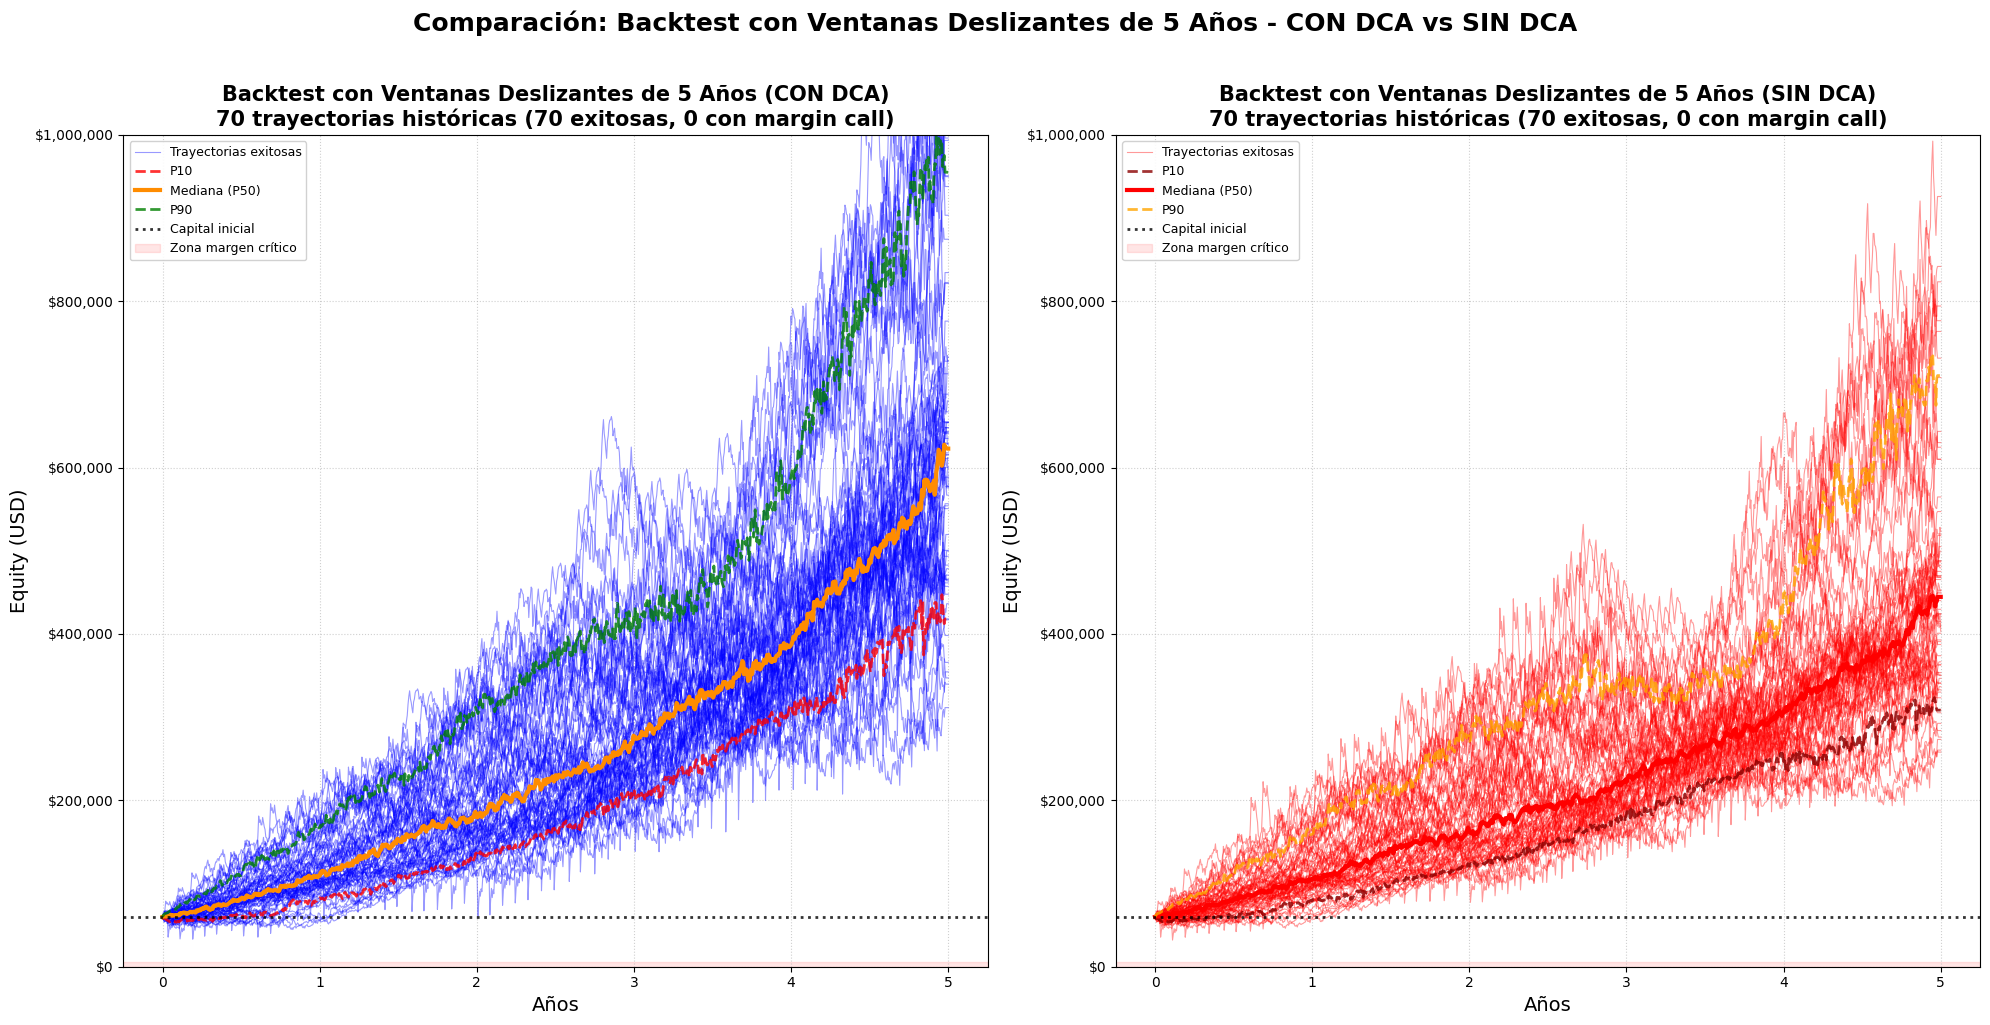


✅ Backtest completo finalizado exitosamente


In [ ]:
if len(all_trajectories_with_dca) > 0 and len(all_trajectories_without_dca) > 0:
    print("\n" + "=" * 80)
    print("📊 Generando gráficas con todas las trayectorias...")
    print("=" * 80)

    # Helper function to pad trajectory
    def pad_trajectory(traj, target_length, final_value=None):
        if len(traj) < target_length:
            pad_value = (
                final_value
                if final_value is not None
                else (traj[-1] if len(traj) > 0 else 0)
            )
            return np.pad(
                traj,
                (0, target_length - len(traj)),
                mode="constant",
                constant_values=pad_value,
            )
        else:
            return traj[:target_length]

    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Calculate max length for both datasets
    all_trajectories_combined = (
        all_trajectories_with_dca + all_trajectories_without_dca
    )
    max_length = max(len(traj) for traj in all_trajectories_combined)
    time_points = np.linspace(0, WINDOW_YEARS, max_length)

    # Helper function to plot on a specific axis
    def plot_on_axis(
        ax, trajectories, final_capitals_list, title_suffix, color_scheme
    ):
        """Plot trajectories on a specific axis."""
        # Separate trajectories by outcome
        success_trajs = []
        margin_call_trajs = []
        for traj, final_cap in zip(trajectories, final_capitals_list):
            if final_cap == 0:
                margin_call_trajs.append(traj)
            else:
                success_trajs.append(traj)

        # Plot successful trajectories
        success_labeled = False
        for traj in success_trajs:
            traj_padded = pad_trajectory(traj, max_length)
            label = "Trayectorias exitosas" if not success_labeled else ""
            ax.plot(
                time_points,
                traj_padded,
                alpha=0.4,
                linewidth=0.8,
                color=color_scheme["success"],
                linestyle="-",
                label=label,
            )
            success_labeled = True

        # Plot margin call trajectories
        margin_labeled = False
        for traj in margin_call_trajs:
            traj_padded = pad_trajectory(traj, max_length, final_value=0)
            label = "Trayectorias con margin call" if not margin_labeled else ""
            ax.plot(
                time_points,
                traj_padded,
                alpha=0.6,
                linewidth=1,
                color="red",
                linestyle="--",
                label=label,
            )
            margin_labeled = True

        # Calculate and plot percentiles
        if len(success_trajs) > 0:
            success_trajs_array = np.array(
                [pad_trajectory(traj, max_length) for traj in success_trajs]
            )
            p10 = np.percentile(success_trajs_array, 10, axis=0)
            p50 = np.percentile(success_trajs_array, 50, axis=0)
            p90 = np.percentile(success_trajs_array, 90, axis=0)

            ax.plot(
                time_points,
                p10,
                color=color_scheme["p10"],
                linewidth=2,
                linestyle="--",
                alpha=0.8,
                label="P10",
            )
            ax.plot(
                time_points,
                p50,
                color=color_scheme["p50"],
                linewidth=3,
                label="Mediana (P50)",
            )
            ax.plot(
                time_points,
                p90,
                color=color_scheme["p90"],
                linewidth=2,
                linestyle="--",
                alpha=0.8,
                label="P90",
            )

        # Add initial capital line
        initial_capital = METAPARAMETERS["initial_capital"]
        ax.axhline(
            initial_capital,
            color="black",
            linestyle=":",
            linewidth=2,
            label="Capital inicial",
            alpha=0.8,
        )

        # Add margin call threshold line
        ax.axhspan(
            0,
            initial_capital * 0.1,
            color="red",
            alpha=0.1,
            label="Zona margen crítico",
        )

        # Formatting
        ax.set_xlabel("Años", fontsize=14)
        ax.set_ylabel("Equity (USD)", fontsize=14)
        title_text = (
            f"Backtest con Ventanas Deslizantes de 5 Años {title_suffix}\n"
            f"{len(trajectories)} trayectorias históricas "
            f"({len(success_trajs)} exitosas, {len(margin_call_trajs)} con margin call)"
        )
        ax.set_title(title_text, fontsize=15, fontweight="bold")
        ax.grid(True, linestyle=":", alpha=0.6)

        # Format y-axis as currency
        currency_formatter = FuncFormatter(lambda value, _: f"${value:,.0f}")
        ax.yaxis.set_major_formatter(currency_formatter)

        # Legend
        ax.legend(loc="upper left", fontsize=9, framealpha=0.9)

    # Calculate max equity across both datasets for consistent y-axis
    max_equity_both = 1000000  # Fixed limit of $1 million

    # Plot CON DCA on left subplot
    plot_on_axis(
        ax1,
        all_trajectories_with_dca,
        final_capitals_with_dca,
        "(CON DCA)",
        {"success": "blue", "p10": "red", "p50": "darkorange", "p90": "green"},
    )
    ax1.set_ylim(0, max_equity_both)

    # Plot SIN DCA on right subplot
    plot_on_axis(
        ax2,
        all_trajectories_without_dca,
        final_capitals_without_dca,
        "(SIN DCA)",
        {"success": "red", "p10": "darkred", "p50": "red", "p90": "orange"},
    )
    ax2.set_ylim(0, max_equity_both)

    # Add overall title
    fig.suptitle(
        "Comparación: Backtest con Ventanas Deslizantes de 5 Años - CON DCA vs SIN DCA",
        fontsize=18,
        fontweight="bold",
        y=1.02,
    )

    plt.tight_layout()
    plt.show()

    print("\n✅ Backtest completo finalizado exitosamente")
else:
    print("\n❌ No se pudieron generar backtests. Verifica los datos.")
